In [1]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint


import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from SDFusion.models.base_model import create_model
from SDFusion.utils.util_3d import read_sdf, render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

/home/antonio/anaconda3/envs/panoptic/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def regular_to_signed_distance(regular_distance_function, threshold):
    # Determine the signs based on the threshold
    signs = np.sign(regular_distance_function - threshold)

    # Preserve actual distances and assign signs
    signed_distance_function = signs * np.abs(regular_distance_function)

    return signed_distance_function

In [4]:
# options for the model. please check `utils/demo_util.py` for more details
from SDFusion.utils.demo_util import SDFusionMM2ShapeOpt

seed = 2023
opt = SDFusionMM2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionMM2ShapeOption initialized.


In [5]:
# initialize SDFusion model
ckpt_path = 'SDFusion/saved_ckpt/sdfusion-mm2shape.pth'
opt.init_model_args(ckpt_path=ckpt_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: SDFusion/saved_ckpt/vqvae-snet-all.pth
[*] loading state_dict with strict=False!
[*] resnet18 successfully loaded from https://download.pytorch.org/models/resnet18-f37072fd.pth.
[*] weight successfully load from: SDFusion/saved_ckpt/sdfusion-mm2shape.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusion-Multi-Modal-Conditional-Shape-Generation-Model
[*] "SDFusion-Multi-Modal-Conditional-Shape-Generation-Model" loaded.


In [9]:
from SDFusion.utils.demo_util import preprocess_image, get_shape_mask, tensor_to_pil
import torchvision.transforms as transforms
from .tools.test_joined_single_image import generate_volume
import trimesh
from pysdf import SDF

# mm2shape
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

# load input shape


mesh = trimesh.load('outputs/joined/mesh_semantics.ply')
box = mesh.bounding_box_oriented.bounds

diff = box[1] - box[0]
diff = np.max(diff)
center = (box[1] + box[0])/2

x_range = (center[0]-diff/2, center[0]+diff/2)
y_range = (center[1]-diff/2, center[1]+diff/2)
z_range = (center[2]-diff/2, center[2]+diff/2)

sdf = SDF(mesh.vertices, mesh.faces)

resulting_volume = generate_volume(x_range, y_range, z_range)
sdf_sampled = sdf(resulting_volume.reshape(-1,3))
sdf_sampled = sdf_sampled.reshape(256, 256, 256)

bed_sdf =torch.Tensor(sdf_sampled)[None, None, ...]
#print(bed_sdf.shape, torch.max(bed_sdf), torch.min(bed_sdf))
#bed_sdf_down = torch.nn.functional.interpolate(bed_sdf, scale_factor=0.25,mode='trilinear')
#print(bed_sdf_down.shape, torch.max(bed_sdf_down), torch.min(bed_sdf_down))

signed_distance_function = regular_to_signed_distance(bed_sdf, 0.5)
print(signed_distance_function.shape, torch.max(signed_distance_function), torch.min(signed_distance_function))

mesh_path='outputs/joined/mesh_semantics.ply'
mesh = trimesh.load(mesh_path)



mask_mode = 'top' # what to keep. check: demo_util.get_shape_mask for other options

# get text
input_txt = "chair with one leg"
bed_txt = 'bed'

# get image
input_img = "data/front3d/0a9c667d-033d-448c-b17c-dc55e6d3c386/rgb_0019.png"
input_mask = "data/front3d/0a9c667d-033d-448c-b17c-dc55e6d3c386/rgb_0019.png"

img_for_vis, img_clean = preprocess_image(input_img, input_mask)
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.Resize((256, 256)),
])
img_clean = transforms(img_clean).unsqueeze(0)

# pack into a dict
test_data = {
    'sdf': signed_distance_function[:,:,90:154,115:179,70:134],
    'img': img_clean,
    'text': [bed_txt],
}

rend_sdf = render_sdf(SDFusion.renderer, (signed_distance_function[:,:,90:154,115:179,70:134] ).to(device))

# visualize input
# for d in [ tensor_to_pil(rend_sdf), img_for_vis ]:
#     display(d)
# print("text prompt: ", input_txt)

# visualize input
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axis('off')
ax[0].imshow(tensor_to_pil(rend_sdf))
ax[0].title.set_text('Input shape')
ax[1].axis('off')
ax[1].imshow(img_for_vis)
ax[1].title.set_text('Input image')

fig.suptitle(f'Text prompt: "{input_txt}"', y=-0.01)
plt.show()


ImportError: attempted relative import with no known parent package

In [ ]:
for i in range(256):
    for j in range(256):
        for k in range(256):
            if signed_distance_function[0,0,i,j,k]<0.6:
                print(i, j, k)

90 143 91
90 143 92
91 131 89
91 132 90
91 142 90
91 143 89
91 143 90
91 143 91
91 143 92
92 131 89
92 132 89
92 137 89
92 138 88
92 138 89
92 139 88
92 139 89
92 140 89
92 141 88
92 141 89
92 142 86
92 142 87
92 142 88
92 142 89
92 142 90
92 143 86
92 143 87
92 143 88
92 143 89
92 143 90
92 143 91
92 144 88
92 144 89
92 144 90
93 138 87
93 138 88
93 138 89
93 139 87
93 139 88
93 139 89
93 140 87
93 140 88
93 140 89
93 141 87
93 141 88
93 141 89
93 142 85
93 142 86
93 142 87
93 142 88
93 142 89
93 142 90
93 143 84
93 143 85
93 143 86
93 143 87
93 143 88
93 143 89
93 143 90
93 143 91
93 144 84
93 144 85
93 144 86
93 144 87
93 144 88
93 144 89
93 145 88
94 139 88
94 139 89
94 141 88
94 142 85
94 142 86
94 142 87
94 142 88
94 142 89
94 142 90
94 143 82
94 143 83
94 143 84
94 143 85
94 143 86
94 143 87
94 143 88
94 143 89
94 143 90
94 143 92
94 144 82
94 144 83
94 144 84
94 144 85
94 144 86
94 144 87
94 144 88
94 144 89
94 147 88
94 148 88
94 149 88
95 142 86
95 142 87
95 142 88
95 142 89


In [ ]:
# inference

# ddim_steps = 100
ddim_steps = 50
ddim_eta = 0.1
uc_scale = 5.

# demo: run four sets of scales
txt_img_scales = [(0., 0.), (1., 0.)]#, (0., 1.), (1., 1.)]

for txt_scale, img_scale in txt_img_scales:
    SDFusion.mm_inference(test_data, mask_mode=mask_mode, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale,
    txt_scale=txt_scale, img_scale=img_scale)
    # save the generation results
    sdf_gen = SDFusion.gen_df
    mesh_gen = sdf_to_mesh(sdf_gen)
    gen_name = f'{out_dir}/mm2shape-gen_shape-txt_{txt_scale}-img_{img_scale}.gif'
    save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

# save input partial shape as well
sdf_part = SDFusion.x_part
mesh_part = sdf_to_mesh(sdf_part)
part_name = f'{out_dir}/mm2shape-part_shape.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_part, nrow=3, out_name=part_name)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.92 GiB total capacity; 8.24 GiB already allocated; 2.69 MiB free; 9.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Input text: chair with one leg
Input image: 


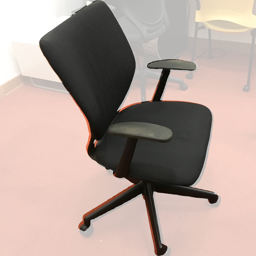

Input partial shape:


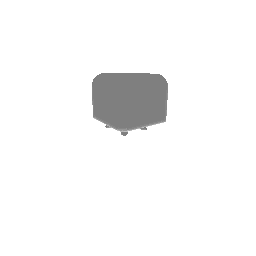

Results (txt strength: 0.0, img strength: 0.0):


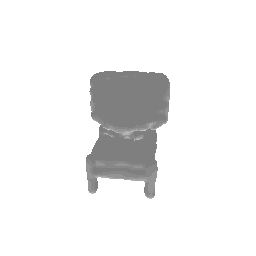

Results (txt strength: 1.0, img strength: 0.0):


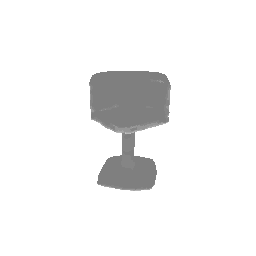

In [ ]:
# visualize the results
print(f'Input text: {input_txt}')
print('Input image: ')
display(img_for_vis)
print('Input partial shape:' )
display(ipy_image(part_name))
for txt_scale, img_scale in txt_img_scales:
    print(f'Results (txt strength: {txt_scale}, img strength: {img_scale}):' )
    gen_name = f'{out_dir}/mm2shape-gen_shape-txt_{txt_scale}-img_{img_scale}.gif'
    display(ipy_image(gen_name))